In [1]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1) Carrega os dados

df = pd.read_csv(
    "dados/MQD_1465_final.csv",
    sep=',',              # separador de colunas
    quoting=csv.QUOTE_ALL,# trata todos os campos como strings entre aspas
    quotechar='"',        # caractere de aspas
    skipinitialspace=True, # remove espaços após as vírgulas,
    encoding='utf-8'     # codificação do arquivo
)

df.columns = df.columns.str.strip() # remove espaços em branco dos nomes das colunas
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

print("Colunas disponíveis:")
print(df.columns.tolist())  


# Verificar o tamanho do arquivo e as primeiras linhas
print("Dimensões do DataFrame:", df.shape)
print("\nPrimeiras linhas:")
print(df.head())

# Verificar nomes das colunas
print("\nColunas disponíveis:")
print(df.columns.tolist())



Colunas disponíveis:
['ItemNumber', 'frase', 'cla_maj_femi', 'qtd_maj_femi', 'cla_maj_masc', 'qtd_maj_masc', 'f1_class', 'f2_class', 'f3_class', 'f4_class', 'm1_class', 'm2_class', 'm3_class', 'm4_class', 'f1_tempo', 'f2_tempo', 'f3_tempo', 'f4_tempo', 'm1_tempo', 'm2_tempo', 'm3_tempo', 'm4_tempo']
Dimensões do DataFrame: (1465, 22)

Primeiras linhas:
   ItemNumber                                              frase cla_maj_femi  \
0           1  Você sabia que o menino que mais vai te dar va...     positiva   
1           2  Hoje com 21 anos, como que por auxilio lá do a...     positiva   
2           3  Nesse momento to evitando ela, e ta me dando u...     negativa   
3           4  Meus sentidos de garota diziam que tinha algum...       neutra   
4           5  Aquela promessa que eu te fiz naquele natal, e...     positiva   

   qtd_maj_femi cla_maj_masc  qtd_maj_masc  f1_class  f2_class  f3_class  \
0             4     positiva             4  positiva  positiva  positiva   
1     

In [4]:

# Ajuste das variaveis alvo  

X = df["frase"]                
y_masc = df["cla_maj_masc"]    # classificação masculino
y_femi = df["cla_maj_femi"]    # classificação feminina

# Split único para manter as MESMAS frases e índices
X_train, X_test, y_masc_train, y_masc_test, y_femi_train, y_femi_test = train_test_split(
    X, y_masc, y_femi,
    test_size=0.2,
    random_state=42,
    stratify=y_masc, # ou y_femi, dependendo de qual rótulo deseja estratificar
)

# 4) Vetorização TF-IDF do texto
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

# Aplicando LogisticRegression sem ajuste de hiperparâmetros

# --- MODELO MASCULINO ---
clf_masc = LogisticRegression(random_state=42, max_iter=1000)
clf_masc.fit(X_train_tfidf, y_masc_train)

# Previsões para o conjunto de teste
y_masc_pred = clf_masc.predict(X_test_tfidf)

# Relatório de classificação
print("=== Modelo para cla_maj_masc ===")
print(classification_report(y_masc_test, y_masc_pred))

# --- MODELO FEMININO ---
clf_femi = LogisticRegression(random_state=42, max_iter=1000)
clf_femi.fit(X_train_tfidf, y_femi_train)

# Previsões para o conjunto de teste
y_femi_pred = clf_femi.predict(X_test_tfidf)

# Relatório de classificação
print("=== Modelo para cla_maj_femi ===")
print(classification_report(y_femi_test, y_femi_pred))


=== Modelo para cla_maj_masc ===
              precision    recall  f1-score   support

    negativa       0.60      0.60      0.60       103
      neutra       0.47      0.14      0.21        66
    positiva       0.56      0.77      0.65       124

    accuracy                           0.57       293
   macro avg       0.54      0.50      0.49       293
weighted avg       0.56      0.57      0.53       293

=== Modelo para cla_maj_femi ===
              precision    recall  f1-score   support

    negativa       0.54      0.52      0.53       106
      neutra       0.40      0.34      0.37        85
    positiva       0.53      0.62      0.57       102

    accuracy                           0.50       293
   macro avg       0.49      0.49      0.49       293
weighted avg       0.50      0.50      0.50       293



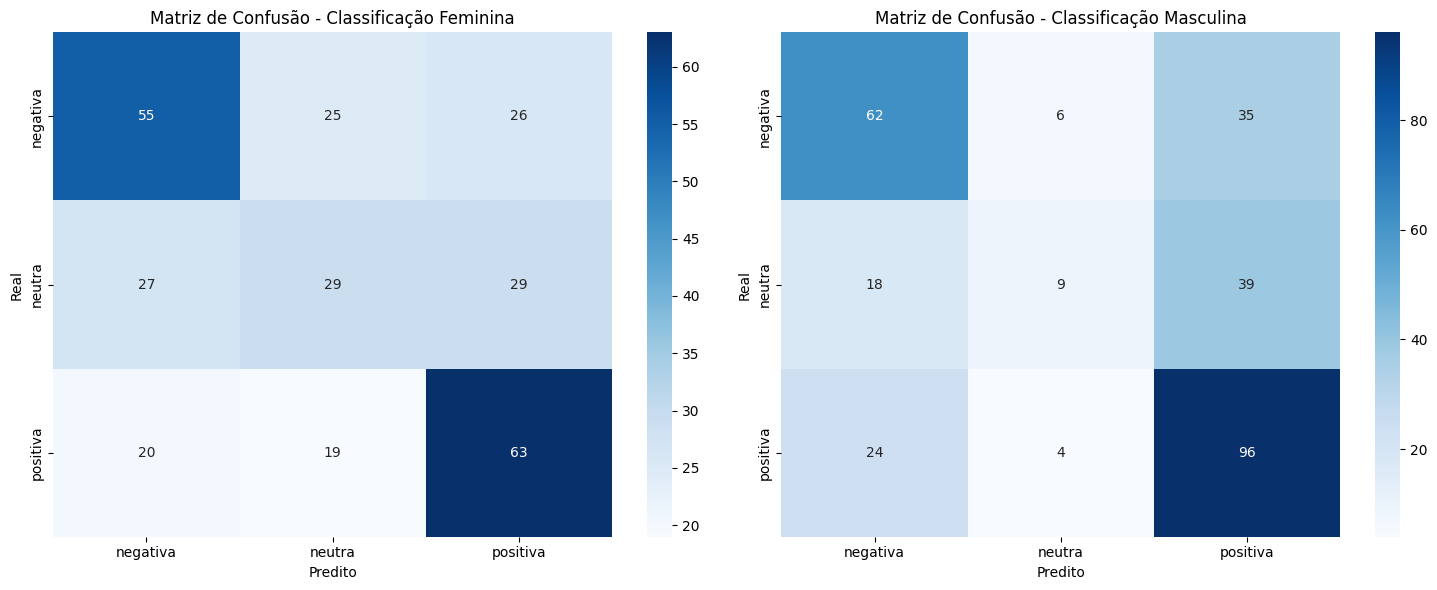

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt

# Criar figura com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Matriz de confusão para classificação feminina
cm_femi = confusion_matrix(y_femi_test, y_femi_pred)
sns.heatmap(cm_femi, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negativa', 'neutra', 'positiva'],
            yticklabels=['negativa', 'neutra', 'positiva'],
            ax=ax1)
ax1.set_title('Matriz de Confusão - Classificação Feminina')
ax1.set_xlabel('Predito')
ax1.set_ylabel('Real')

# Matriz de confusão para classificação masculina
cm_masc = confusion_matrix(y_masc_test, y_masc_pred)
sns.heatmap(cm_masc, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negativa', 'neutra', 'positiva'],
            yticklabels=['negativa', 'neutra', 'positiva'],
            ax=ax2)
ax2.set_title('Matriz de Confusão - Classificação Masculina')
ax2.set_xlabel('Predito')
ax2.set_ylabel('Real')


plt.tight_layout()
plt.show()

In [11]:
# Criar um DataFrame com os resultados para análise
resultados_df = pd.DataFrame({
    'id': X_test.index,
    'frase': X_test,
    'real_masc': y_masc_test,
    'pred_masc': y_masc_pred,
    'acerto_masc': y_masc_test == y_masc_pred,
    'real_femi': y_femi_test, 
    'pred_femi': y_femi_pred,
    'acerto_femi': y_femi_test == y_femi_pred
})

# Adicionar coluna indicando se ambos acertaram/erraram
resultados_df['ambos_acertaram'] = resultados_df['acerto_masc'] & resultados_df['acerto_femi']
resultados_df['ambos_erraram'] = ~resultados_df['acerto_masc'] & ~resultados_df['acerto_femi']

# Exibir algumas estatísticas
print("\nEstatísticas de acertos:")
print(f"Total de casos: {len(resultados_df)}")
print(f"Acertos masculinos: {resultados_df['acerto_masc'].sum()}")
print(f"Acertos femininos: {resultados_df['acerto_femi'].sum()}")
print(f"Ambos acertaram: {resultados_df['ambos_acertaram'].sum()}")
print(f"Ambos erraram: {resultados_df['ambos_erraram'].sum()}")

# Exibir algumas linhas do DataFrame para verificação
print("\nExemplos de casos onde ambos acertaram:")
print(resultados_df[resultados_df['ambos_acertaram']].head())


Estatísticas de acertos:
Total de casos: 293
Acertos masculinos: 167
Acertos femininos: 147
Ambos acertaram: 110
Ambos erraram: 89

Exemplos de casos onde ambos acertaram:
        id                                              frase real_masc  \
1045  1045  Já basta, não aguentando mais, eu discuti com ...  negativa   
1365  1365  Meu coração acelera, minhas mãos ficam geladas...  positiva   
413    413  Só você sabia que eu não chorava por ter ficad...  negativa   
255    255  Fora que acordar com um eu te amo, torna o dia...  positiva   
292    292            Para ser feliz não existe poção mágica.  positiva   

     pred_masc  acerto_masc real_femi pred_femi  acerto_femi  ambos_acertaram  \
1045  negativa         True  negativa  negativa         True             True   
1365  positiva         True  positiva  positiva         True             True   
413   negativa         True  negativa  negativa         True             True   
255   positiva         True  positiva  positiva     